Postprocessing bottom line

In [ ]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt


Import video

In [497]:
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_3" / "Recording_3_normal_speed.mp4"
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)


Get data (horizontal_lines)

In [498]:
# Define the path to the CSV file
input_data_path = project_root / "notebook"/ "lane_detection" / "intermediate_data" / "horizontal_lines_3.csv"

# Load the CSV file into a DataFrame
horizontal_lines = pd.read_csv(input_data_path)

Define output video

In [499]:
# # Define the codec and create a VideoWriter object to save the modified frames
# output_path = project_root / "data" / "recording_2" / "Adjusted_Bottom_line_video.mp4"
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
# fps = int(cap.get(cv2.CAP_PROP_FPS))
# frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))


Define functions

In [500]:
'''Disegna la linea sul frame'''
def write_line_on_frame(frame, line):
    # Create a copy of the original frame to draw the first line
    modified_frame = np.copy(frame)

    # Extract the first line's rho and theta
    if line:
        rho, theta = line
        # Calculate the endpoints of the line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # Draw the first line on the frame
        cv2.line(modified_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # return the modified frame
    return modified_frame

Prova processing su rho

In [501]:
# # Extract the rho and theta values from the DataFrame
# rhos = horizontal_lines['rho'].values
# thetas = horizontal_lines['theta'].values

# # Compute distances between consecutive rho values
# distances = np.diff(rhos)

# # Compute the mean and standard deviation of the distances
# mean_distance = np.mean(distances)
# std_distance = np.std(distances)

# # Define a threshold for outliers (e.g., 2 standard deviations from the mean)
# threshold = 1 * std_distance

# # Identify outliers (distances greater than the threshold)
# outliers_indices = np.where(distances > threshold)[0]


# while len(outliers_indices) > 0:
#     print(f"Number of outliers: {len(outliers_indices)}")
#     # Interpolate the missing rho values for outliers (linear interpolation)
#     for i in outliers_indices:
#         # Find the closest non-outlier elements before and after the current index
#         prev_index = next((j for j in range(i - 1, -1, -1) if j not in outliers_indices), None) + 1
#         next_index = next((j for j in range(i + 1, len(rhos)) if j not in outliers_indices), None) + 1

#         if prev_index is not None and next_index is not None:
#             # Linear interpolation between the two closest non-outlier elements
#             rhos[i + 1] = rhos[prev_index] + (rhos[next_index] - rhos[prev_index]) * (i + 1 - prev_index) / (next_index - prev_index)
#         elif prev_index is not None:
#             # If there's no next element, use the previous value
#             rhos[i + 1] = rhos[prev_index]
#         elif next_index is not None:
#             # If there's no previous element, use the next value
#             rhos[i + 1] = rhos[next_index]
#         else:
#             print("No non-outlier elements found. Unable to interpolate.")

#     # Recompute distances between consecutive rho values
#     distances = np.diff(rhos)

#     # Identify outliers (distances greater than the threshold)
#     outliers_indices = np.where(distances > threshold)[0]


# # Combine the adjusted rho values with the original theta values
# adjusted_horizontal_lines = list(zip(rhos, thetas))

# # Reset the video to the beginning
# cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# # Loop through each frame in the video
# frame_index = 0
# while frame_index < 200:
#     ret, video_frame = cap.read()
#     if not ret:
#         print("End of video or failed to read the frame.")
#         break
#     modified_frame = write_line_on_frame(video_frame, adjusted_horizontal_lines[frame_index])

#     # Write the modified frame to the output video
#     out.write(modified_frame)

#     print(f"Frame {frame_index} processed.")
#     # Increment the frame index
#     frame_index += 1


# # Release the video capture and writer objects
# cap.release()
# out.release()

# print(f"Adjusted video saved to {output_path}")

Postprocessing sul punto più vicino all'origine

In [502]:
# Calcola il punto  per ogni linea
intersection_points = []

for rho, theta in zip(horizontal_lines['rho'], horizontal_lines['theta']):
    # Calcola i coefficienti della linea
    x = np.cos(theta) * rho
    y = np.sin(theta) * rho

    # Aggiungi il punto  alla lista
    intersection_points.append((x, y))

# intersection_points = np.array(intersection_points)
print(intersection_points)


[(np.float64(-11.626609442059847), np.float64(1034.7682403433478)), (np.float64(0.0), np.float64(0.0)), (np.float64(-15.900141978229726), np.float64(1033.5092285849505)), (np.float64(-19.458718861209828), np.float64(1031.3120996441282)), (np.float64(-19.077819677751098), np.float64(1030.2022625985603)), (np.float64(-19.95081503816037), np.float64(1027.4669744652786)), (np.float64(-13.71489512975431), np.float64(1028.6171347316035)), (np.float64(-14.888492230155252), np.float64(1027.3059638807224)), (np.float64(-15.081945945945874), np.float64(1025.5723243243242)), (np.float64(-16.24357682619612), np.float64(1023.345340050378)), (np.float64(-11.883871839934946), np.float64(1022.0129782344195)), (np.float64(-20.09323757192905), np.float64(1018.0573703110806)), (np.float64(-14.54927565802893), np.float64(1018.4492960620282)), (np.float64(-16.65475550779139), np.float64(1015.9400859752823)), (np.float64(-13.907504690431487), np.float64(1015.2478424015009)), (np.float64(-17.75138461538462),

Prova usando le funzioni di Davide

In [503]:
def plot_trajectory(df):
    plt.figure(figsize=(8,6))
    plt.plot(df['X'], -df['Y'], 'o-', label='Cleaned Trajectory')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cleaned Trajectory')
    plt.legend()
    plt.show()

In [ ]:
def remove_outliers(df, threshold=1):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
    
    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()
    distances = np.sqrt(dx**2 + dy**2)
    # Define outlier threshold
    median_dist = distances.median()
    std_dist = distances.std()
    print('Median distance:', median_dist)
    print('Standard deviation of distances:', std_dist)
    outlier_threshold = threshold * std_dist

    mask = []
    
    for i in range(0, len(distances)-1):

        # Remove points that are  (0, 0)  (the ones that I set when it doesn't detect any line)
        if df['X'].iloc[i] == 0 and df['Y'].iloc[i] == 0:
            mask.append(i)
            prev_index = i - 1
            while prev_index in mask and prev_index >= 0:
                prev_index -= 1
            if prev_index < 0:
                print("No valid previous index found. Breaking.")
                break
            distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
            continue
        if distances[i] > outlier_threshold:
            # Create a mask to identify the outlier point
            mask.append(i)
            # convert the next point distance in the distance with respect to the previous point
            if i < len(distances) - 1 and i > 0:
                # select the previous point as the last point evaluated non present in the mask
                prev_index = i - 1
                while prev_index in mask and prev_index >= 0:
                    prev_index -= 1
                if prev_index < 0:
                    print("No valid previous index found. Breaking.")
                    break
                distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
                print('New distance:', distances[i+1], 'for point:', i+1, 'with respect to point:', prev_index)
   # Remove the outlier points from the DataFrame
    df = df.drop(mask)
    print('Outliers removed:', len(mask))

    # compute means and standard deviations of points
    mean_x = df['X'].mean()
    mean_y = df['Y'].mean()
    std_x = df['X'].std()
    std_y = df['Y'].std()   

    threshold_std = 1

    # Remove points too far from the mean
    df = df[(df['X'] > mean_x - threshold_std*std_x) & (df['X'] < mean_x + threshold_std*std_x) & (df['Y'] > mean_y - threshold_std*std_y) & (df['Y'] < mean_y + threshold_std*std_y)]
    
    return df

In [505]:
def median_filter(df, kernel_size=5):
    """
    Smooths the X and Y coordinates using a median filter to reduce noise.
    """
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df['X'] = medfilt(df['X'], kernel_size=kernel_size)
    df['Y'] = medfilt(df['Y'], kernel_size=kernel_size)
    
    return df

In [506]:
def Savitzky_Golay_filter(df, window_length=25, polyorder=1):
    """
    Smooths the X and Y coordinates using Savitzky-Golay filter to reduce noise.
    """
    df['X'] = savgol_filter(df['X'], window_length=window_length, polyorder=polyorder)
    df['Y'] = savgol_filter(df['Y'], window_length=window_length, polyorder=polyorder)
    
    # Round the smoothed coordinates to integers
    df['X'] = df['X'].round().astype(int)
    df['Y'] = df['Y'].round().astype(int)
    
    return df

In [507]:
def interpolate_missing_coordinates(df, start_frame=0, end_frame=200):
    """
    Interpolate the missing coordinates between the frames from start_frame to end_frame.
    Ensures a smooth trajectory by interpolating both X and Y coordinates.
    """
    # Create a DataFrame with all frames from start_frame to end_frame
    all_frames = pd.DataFrame({'Frame': range(start_frame, end_frame + 1)})
    
    # Merge with the original dataframe
    df_full = pd.merge(all_frames, df, on='Frame', how='left')
    
    # Interpolate the missing 'X' and 'Y' coordinates (linear interpolation)
    df_full['X'] = df_full['X'].interpolate(method='linear')
    df_full['Y'] = df_full['Y'].interpolate(method='linear')

    # Fill any remaining NaN values using forward and backward filling
    df_full['X'] = df_full['X'].bfill().ffill()
    df_full['Y'] = df_full['Y'].bfill().ffill()
    
    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)
    
    return df_full

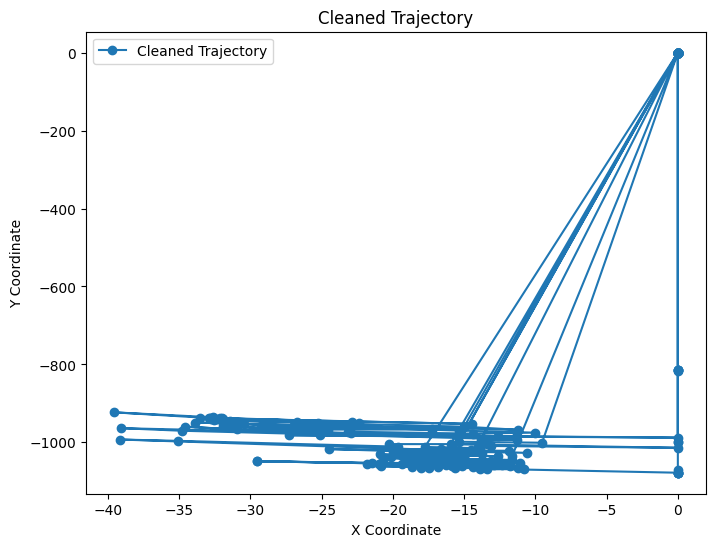

Median distance: 2.993864799101453
Standard deviation of distances: 258.99720513066137
New distance: 1078.0 for point: 208 with respect to point: 144
New distance: 262.9999999999999 for point: 212 with respect to point: 144
New distance: 1078.0 for point: 213 with respect to point: 144
New distance: 1078.0 for point: 216 with respect to point: 144
New distance: 1078.0 for point: 218 with respect to point: 144
Outliers removed: 88


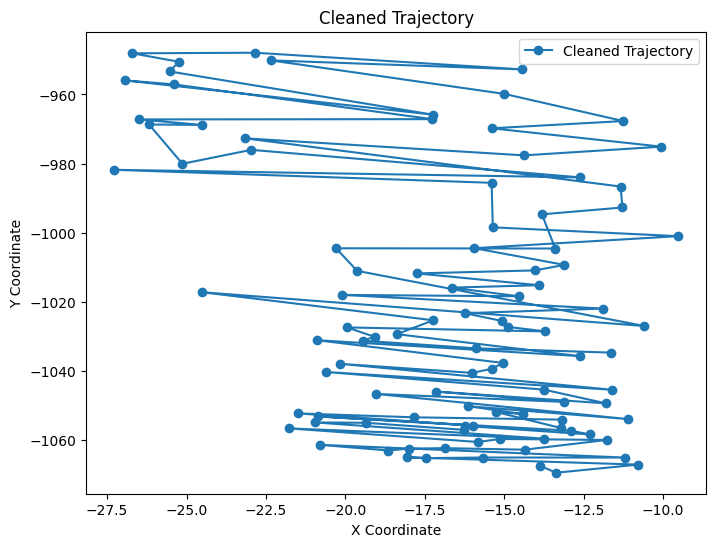

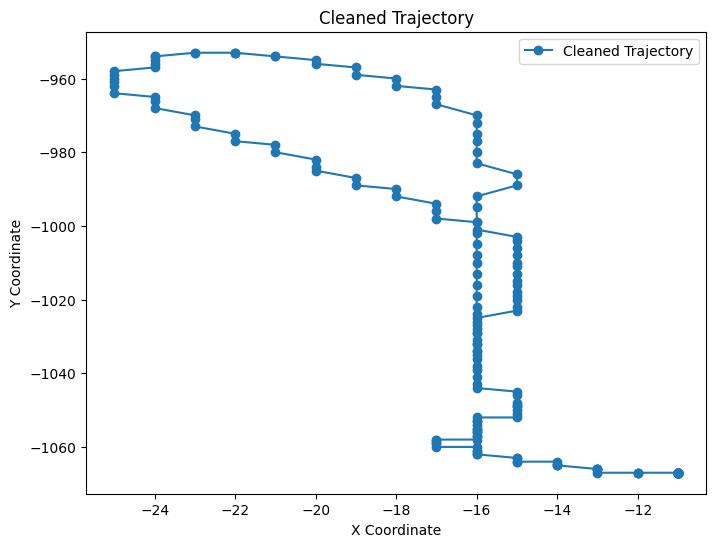

len(points_interpolated): 201
mean: -15.582089552238806 1027.5174129353234


In [508]:
# remove outliers
# Create a DataFrame from intersection_points
points_df = pd.DataFrame(intersection_points, columns=['X', 'Y'])
points_df['Frame'] = range(len(points_df))
plot_trajectory(points_df)

# Reorder columns to have 'Frame', 'X', 'Y'
points_df = points_df[['Frame', 'X', 'Y']]

# Remove outliers
points_cleaned = remove_outliers(points_df)

plot_trajectory(points_cleaned)

# Smooth the trajectory to reduce noise
points_smoothed = median_filter(points_cleaned)

# Interpolate missing coordinates
points_interpolated = interpolate_missing_coordinates(points_smoothed)

#plot
plot_trajectory(points_interpolated)
print("len(points_interpolated):", len(points_interpolated))
print('mean:', points_interpolated['X'].mean(), points_interpolated['Y'].mean())

Riconverto i punti in linee

In [509]:
# Riconversione dei punti in linee (rho e theta)
reconverted_lines = []

for x, y in points_interpolated[['X', 'Y']].values:
    rho = np.sqrt(x**2 + y**2)  # Distanza dall'origine
    theta = np.arctan2(y, x)    # Angolo rispetto all'asse x
    reconverted_lines.append((rho, theta))
print("length of reconverted lines:", len(reconverted_lines))
print(reconverted_lines)

length of reconverted lines: 201
[(np.float64(1035.1236641097526), np.float64(1.5862540327170678)), (np.float64(1034.123783693229), np.float64(1.5862689797578329)), (np.float64(1032.124023555309), np.float64(1.586298960719913)), (np.float64(1031.124143835261), np.float64(1.5863139948097105)), (np.float64(1029.124385096379), np.float64(1.5863441506304816)), (np.float64(1028.1245060789088), np.float64(1.5863592725319082)), (np.float64(1026.1247487513397), np.float64(1.5863896047454682)), (np.float64(1025.1248704426207), np.float64(1.586404815230054)), (np.float64(1023.1099647642965), np.float64(1.585458032715223)), (np.float64(1022.1100723503315), np.float64(1.5854723767482477)), (np.float64(1020.1102881551583), np.float64(1.585501149172748)), (np.float64(1019.1103963751915), np.float64(1.5855155777297472)), (np.float64(1018.1105048078033), np.float64(1.5855300346274692)), (np.float64(1016.1107223132723), np.float64(1.5855590337797192)), (np.float64(1015.1108313873909), np.float64(1.5855

Generate video

In [510]:


# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Define the codec and create a VideoWriter object to save the modified frames
output_path = project_root / "data" / "recording_3" / "Adjusted_Bottom_line_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# Loop through each frame in the video
frame_index = 0
while frame_index < len(reconverted_lines):
    ret, video_frame = cap.read()
    if not ret:
        print("End of video or failed to read the frame at iteration", frame_index)
        break
    modified_frame = write_line_on_frame(video_frame, reconverted_lines[frame_index])

    # Write the modified frame to the output video
    out.write(modified_frame)

    # Increment the frame index
    frame_index += 1

# Release the video capture and writer objects
# cap.release()
out.release()

print(f"Adjusted video saved to {output_path}")

Adjusted video saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_3\Adjusted_Bottom_line_video.mp4


In [511]:
# Convert reconverted_lines to a DataFrame
reconverted_lines_df = pd.DataFrame(reconverted_lines, columns=['rho', 'theta'])

# Define the path to save the reconverted lines
output_path_lines = project_root / "data" / "auxiliary_data" / "lane_lines" / "horizontal_lines_3.csv"

# Save the DataFrame to a CSV file
reconverted_lines_df.to_csv(output_path_lines, index=False)

print(f"Reconverted lines saved to {output_path_lines}")

Reconverted lines saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\auxiliary_data\lane_lines\horizontal_lines_3.csv


Altro approccio

In [512]:
# intersection_points = np.array(intersection_points)
# # Extract the x and y values from intersection_points
# xs = intersection_points[:,0]
# ys = intersection_points[:,1]

# # Compute the distance between consecutive points
# dx = np.diff(xs)
# dy = np.diff(ys)
# distances = np.sqrt(dx**2 + dy**2)

# # Compute the mean and standard deviation of the distances
# mean_distance = np.mean(distances)
# std_distance = np.std(distances)

# print(xs)
# print(ys)

In [513]:
# xs_copy = xs.copy()
# ys_copy = ys.copy()

# # Define a threshold for outliers (e.g., 2 standard deviations from the mean)
# threshold = 1 * mean_distance

# # Identify outliers (distances greater than the threshold)
# outliers_indices = np.where(distances > threshold)[0]

# max_iterations = 10000
# while (len(outliers_indices) > 0 ):
#     max_iterations -= 1
#     print(f"Number of outliers: {len(outliers_indices)}")
#     print(outliers_indices)

#     # Interpolate the missing x and y values for outliers (linear interpolation)
#     i = outliers_indices[0]
#     print("i:",i)
    
#     # Find the closest non-outlier elements before and after the current index
#     prev_index = next((j for j in range(i - 1, -1, -1) if j not in outliers_indices), None)
#     next_index = next((j for j in range(i + 1, len(xs_copy)) if j not in outliers_indices), None)

#     if prev_index is not None:
#         prev_index = prev_index +1
#     if next_index is not None:
#         next_index = next_index +1


#     if prev_index is not None and next_index is not None:
#         # Linear interpolation between the two closest non-outlier elements
#         xs_copy[i + 1] = xs_copy[prev_index] + (xs_copy[next_index] - xs_copy[prev_index]) * (i + 1 - prev_index) / (next_index - prev_index)
#         ys_copy[i + 1] = ys_copy[prev_index] + (ys_copy[next_index] - ys_copy[prev_index]) * (i + 1 - prev_index) / (next_index - prev_index)
#     elif prev_index is not None:
#         # If there's no next element, use the previous value
#         xs_copy[i + 1] = xs_copy[prev_index]
#         ys_copy[i + 1] = ys_copy[prev_index]
#     elif next_index is not None:
#         # If there's no previous element, use the next value
#         xs_copy[i + 1] = xs_copy[next_index]
#         ys_copy[i + 1] = ys_copy[next_index]
#     else:
#         print("No non-outlier elements found. Unable to interpolate.")

#     # Recompute distances between consecutive points
#     dx = np.diff(xs_copy)
#     dy = np.diff(ys_copy)
#     distances = np.sqrt(dx**2 + dy**2)

#     # Identify outliers (distances greater than the threshold)
#     outliers_indices = np.where(distances > threshold)[0]


# # Combine the adjusted x and y values in a dataset
# adjusted_intersection_points = np.column_stack((xs_copy, ys_copy))



Riconverto i punti in linee


In [514]:
# # Riconversione dei punti in linee (rho e theta)
# reconverted_lines = []

# for x, y in adjusted_intersection_points:
#     rho = np.sqrt(x**2 + y**2)  # Distanza dall'origine
#     theta = np.arctan2(y, x)    # Angolo rispetto all'asse x
#     reconverted_lines.append((rho, theta))
# print("length of reconverted lines:", len(reconverted_lines))
# print(reconverted_lines)

Salva il video con le nuove linee

In [515]:
# # Define the relative path to the video file
# notebook_dir = Path().resolve()
# project_root = notebook_dir.parent.parent
# video_path = project_root / "data" / "recording_2" / "Recording_2_normal_speed.mp4"
# video_path = str(video_path)

# # Load the video
# cap = cv2.VideoCapture(video_path)

# # Reset the video to the beginning
# cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# # Define the codec and create a VideoWriter object to save the modified frames
# output_path = project_root / "data" / "recording_2" / "Adjusted_Bottom_line_video.mp4"
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
# fps = int(cap.get(cv2.CAP_PROP_FPS))
# frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# # Loop through each frame in the video
# frame_index = 0
# while True:
#     ret, video_frame = cap.read()
#     if not ret:
#         print("End of video or failed to read the frame at iteration", frame_index)
#         break
#     modified_frame = write_line_on_frame(video_frame, reconverted_lines[frame_index])

#     # Write the modified frame to the output video
#     out.write(modified_frame)

#     # Increment the frame index
#     frame_index += 1

# # Release the video capture and writer objects
# cap.release()
# out.release()

# print(f"Adjusted video saved to {output_path}")